In [1]:
import numpy as np
import matplotlib.pyplot as plt
import h5py
from scipy.io import loadmat
import os
from torchvision.transforms import v2
import cv2
import torchvision.transforms as transforms
import torch
from PIL import Image
from tqdm.auto import tqdm

In [2]:
data_dir = "/home/kaiwensheng/Work/oeg_visual_decoding/data/tvsd_data/"

monkey_name = "monkeyF"
data_filename = f"{monkey_name}_THINGS_MUA_trials.mat"
stim_filename = f"{monkey_name}_things_imgs.mat"

In [3]:
brain_regions = {
    'monkeyF': {
        'V1': (0, 512),
        'IT': (512, 832),
        'V4': (832, 1024)
    },
    'monkeyN': {
        'V1': (0, 512),
        'V4': (512, 768),
        'IT': (768, 1024)
    }
}
monkey_brain_regions = brain_regions[monkey_name]

"""
In monkeyN

1:512 =  V1
513:768 = V4
769:1024 = IT
In monkeyF

1:512 =  V1
513:832 = IT
833:1024 = V4
"""

'\nIn monkeyN\n\n1:512 =  V1\n513:768 = V4\n769:1024 = IT\nIn monkeyF\n\n1:512 =  V1\n513:832 = IT\n833:1024 = V4\n'

In [4]:
def _ref_to_str(ref):
    v = f[ref][()]
    if isinstance(v, bytes):
        return v.decode("utf-8")
    v = np.array(v)
    if v.dtype.kind in {"S", "U"}:
        return "".join(v.astype(str).flatten())
    if v.dtype.kind in {"i", "u"}:
        return "".join(map(chr, v.flatten()))
    return str(v)

with h5py.File(f"{data_dir}/{stim_filename}", "r") as f:
    train_imgs = f["train_imgs"]
    test_imgs = f["test_imgs"]
    print(train_imgs.keys())

    train_classes = train_imgs["class"][...]
    train_local_refs = train_imgs["local_path"][...]
    train_things_paths = train_imgs["things_path"][...]
    train_classes = np.array([_ref_to_str(ref) for ref in train_classes.flatten()]).reshape(train_classes.shape)
    train_local_paths = np.array([_ref_to_str(ref) for ref in train_local_refs.flatten()]).reshape(train_local_refs.shape)
    train_things_paths = np.array([_ref_to_str(ref) for ref in train_things_paths.flatten()]).reshape(train_things_paths.shape)

    test_classes = test_imgs["class"][...]
    test_local_paths = test_imgs["local_path"][...]
    test_things_paths = test_imgs["things_path"][...]
    test_classes = np.array([_ref_to_str(ref) for ref in test_classes.flatten()]).reshape(test_classes.shape)
    test_local_paths = np.array([_ref_to_str(ref) for ref in test_local_paths.flatten()]).reshape(test_local_paths.shape)
    test_things_paths = np.array([_ref_to_str(ref) for ref in test_things_paths.flatten()]).reshape(test_things_paths.shape)

<KeysViewHDF5 ['class', 'local_path', 'things_path']>


In [5]:
train_things_paths, train_things_paths.shape, test_things_paths.shape

(array([['aardvark\\aardvark_01b.jpg'],
        ['aardvark\\aardvark_02s.jpg'],
        ['aardvark\\aardvark_03s.jpg'],
        ...,
        ['zucchini\\zucchini_10s.jpg'],
        ['zucchini\\zucchini_11s.jpg'],
        ['zucchini\\zucchini_12s.jpg']], dtype='<U45'),
 (22248, 1),
 (100, 1))

In [6]:
file_path = f"{data_dir}/{data_filename}"
with h5py.File(file_path, "r") as f:
    print(f.keys())
    allmua = f["ALLMUA"][...]
    allmat = f["ALLMAT"][...]
    tb = f["tb"][...]
    # data = {k: f[k][()] for k in f.keys()}

<KeysViewHDF5 ['ALLMAT', 'ALLMUA', 'tb']>


In [7]:
mapping = loadmat(f"{data_dir}/{monkey_name}_1024chns_mapping_20220105.mat")["mapping"].flatten() - 1
mapping, mapping.max(), mapping.min()

(array([  32,   33,   34, ..., 1021, 1022, 1023], dtype=uint16), 1023, 0)

In [8]:
allmua = allmua[..., mapping]
allmua.shape # [#time-points #electrode #trial_idx]

(300, 25248, 1024)

In [9]:
T, n_electrodes, n_trials = allmua.shape

In [10]:
train_stim_indices = allmat[1].astype(np.int32)
test_stim_indices = allmat[2].astype(np.int32)

In [11]:
train_stim_indices.shape, test_stim_indices.shape, train_stim_indices.max(), test_stim_indices.max(), train_stim_indices.min(), test_stim_indices.min()

((25248,), (25248,), 22248, 100, 0, 0)

In [12]:
train_stim_indices.min(), train_stim_indices.max()

(0, 22248)

In [13]:
# store the train and validation sets
# validation set is another 10% of the training set
train_set_size = np.sum(train_stim_indices > 0)
val_set_size = train_set_size // 20
new_train_set_size = train_set_size - val_set_size
all_train_indices = np.argwhere(train_stim_indices > 0).flatten()
np.random.seed(0)
np.random.shuffle(all_train_indices)
train_indices = all_train_indices[:new_train_set_size]
val_indices = all_train_indices[new_train_set_size:]

test_indices = np.argwhere(test_stim_indices > 0).flatten()

all_train_indices.shape, train_indices.shape, val_indices.shape, test_indices.shape

((22248,), (21136,), (1112,), (3000,))

In [14]:
allmua.shape

(300, 25248, 1024)

## Get reliabiilty index from the data

In [105]:
file_path = f"{data_dir}/{monkey_name}_THINGS_normMUA.mat"
with h5py.File(file_path, "r") as f:
    print(f.keys())
    reliab = f["reliab"][...]
    normalized_train_mua = f["train_MUA"][...]
    print(reliab.shape, normalized_train_mua.shape)

<KeysViewHDF5 ['SNR', 'SNR_max', 'lats', 'oracle', 'reliab', 'tb', 'test_MUA', 'test_MUA_reps', 'train_MUA']>
(435, 1024) (22248, 1024)


In [16]:
reliab = reliab.mean(0)

In [17]:
reliab_threshold = 0.3
good_electrodes = reliab >= reliab_threshold
good_electrodes.shape, good_electrodes.sum()

((1024,), 606)

In [18]:
new_train_things_paths = train_things_paths[train_stim_indices[train_indices] - 1]
new_val_things_paths = train_things_paths[train_stim_indices[val_indices] - 1]
new_test_things_paths = test_things_paths[test_stim_indices[test_indices] - 1]

In [107]:
normalized_train_mua[:, good_electrodes].min(), normalized_train_mua[:, good_electrodes].max()

(-2.401606849743131, 70.99506053883687)

## get the image stimulus

In [19]:
images_dir = f"/home/kaiwensheng/Work/oeg_visual_decoding/data/oeg_data/Natural_scene/object_images"

In [20]:
def center_crop(img):
    return v2.functional.crop(img, top=115, left=260, height=150, width=150)
    
def get_transform(name, stimulus_size):
    # normalizes between -1 and 1
    mean = 0.5 
    std = 0.5 

    if 'dorsal' in name.lower(): 
        transform = transforms.Compose([transforms.Lambda(center_crop),  # crop every video to 135 x 135
                    transforms.Resize(stimulus_size),
                    transforms.ToTensor(),
                    transforms.Normalize(mean=mean,
                                std=std)])
        
    elif 'ventral' in name.lower():
        transform = transforms.Compose([transforms.Resize(stimulus_size), # no crop
                                transforms.ToTensor(),
                                # transforms.Normalize(mean=mean, std=std)
                                ]) 
    else:
        raise ValueError(f"Name {name} not supported for transforms.")   

    return transform

In [21]:
im_channels = 3
im_size = 256

transform = get_transform("ventral", im_size)
transform

Compose(
    Resize(size=256, interpolation=bilinear, max_size=None, antialias=True)
    ToTensor()
)

In [22]:
train_images_arr = np.zeros((new_train_things_paths.shape[0], im_size, im_size, im_channels), dtype=np.float32)
val_images_arr = np.zeros((new_val_things_paths.shape[0], im_size, im_size, im_channels), dtype=np.float32)
test_images_arr = np.zeros((new_test_things_paths.shape[0], im_size, im_size, im_channels), dtype=np.float32)

for i_img, img_path in enumerate(tqdm(new_train_things_paths)):
    img_path = img_path[0]
    img_path = img_path.replace("\\", "/")
    full_img_path = f"{images_dir}/{img_path}"
    img = cv2.imread(full_img_path)
    img = Image.fromarray(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    img = transform(img).numpy().transpose(1, 2, 0)
    assert img.min() >= 0 and img.max() <= 1
    
    train_images_arr[i_img] = img

  0%|          | 0/21136 [00:00<?, ?it/s]

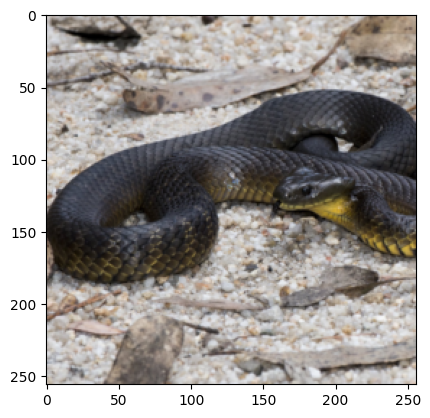

In [23]:
plt.imshow(img)

In [24]:
for i_img, img_path in enumerate(tqdm(new_val_things_paths)):
    img_path = img_path[0]
    img_path = img_path.replace("\\", "/")
    full_img_path = f"{images_dir}/{img_path}"
    img = cv2.imread(full_img_path)
    img = Image.fromarray(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    img = transform(img).numpy().transpose(1, 2, 0)
    
    val_images_arr[i_img] = img


for i_img, img_path in enumerate(tqdm(new_test_things_paths)):
    img_path = img_path[0]
    img_path = img_path.replace("\\", "/")
    full_img_path = f"{images_dir}/{img_path}"
    img = cv2.imread(full_img_path)
    img = Image.fromarray(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    img = transform(img).numpy().transpose(1, 2, 0)
    
    test_images_arr[i_img] = img

  0%|          | 0/1112 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

## Neural activity normalization

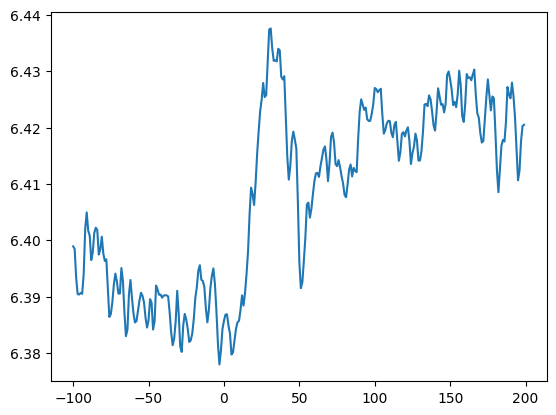

In [109]:
region = 'V4'
range_vals = monkey_brain_regions[region]
plt.plot(tb, allmua[:, train_indices, range_vals[0]].mean(1))

### Use mean training time series for normalization

- first binned at 20ms

In [111]:
bin_size = 20  # in ms
n_bins = T // bin_size
print(f"Number of bins: {n_bins}, each bin size: {bin_size} ms")

Number of bins: 15, each bin size: 20 ms


In [112]:
binned_allmua = np.zeros((n_bins, n_electrodes, n_trials), dtype=allmua.dtype)
for i in tqdm(range(n_bins)):
    start_idx = i * bin_size
    end_idx = start_idx + bin_size
    binned_allmua[i] = allmua[start_idx:end_idx].mean(0)

  0%|          | 0/15 [00:00<?, ?it/s]

In [113]:
mean_train_allmua = binned_allmua[:, train_indices, :].mean(1, keepdims=True)
std_train_allmua = binned_allmua[:, train_indices, :].std(1, keepdims=True)
mean_train_allmua.shape, std_train_allmua.shape

((15, 1, 1024), (15, 1, 1024))

In [114]:
binned_allmua -= mean_train_allmua
binned_allmua /= std_train_allmua

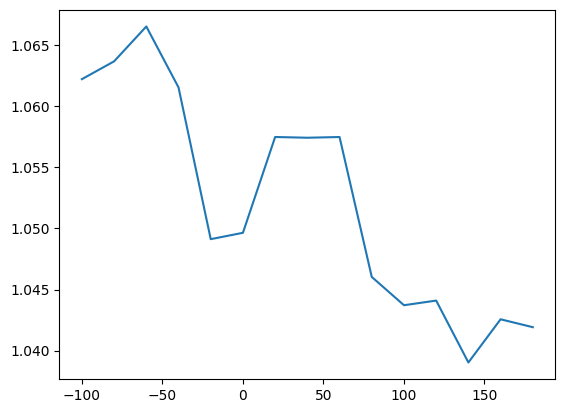

In [116]:
region = 'V4'
range_vals = monkey_brain_regions[region]
plt.plot(tb[::bin_size], std_train_allmua[:, 0, range_vals[0]+23])

In [117]:
binned_allmua[..., good_electrodes].min(), binned_allmua[..., good_electrodes].max()

(-28.563104544844506, 329.0019119709785)

In [99]:
range_vals

{'V1': (0, 512), 'IT': (512, 832), 'V4': (832, 1024)}

In [123]:
deleted_index_dict = dict()
for brain_region in monkey_brain_regions.keys():
    deleted_index_dict[brain_region] = list()
    range_vals = monkey_brain_regions[brain_region]
    for i in range(range_vals[0], range_vals[1]):
        if not good_electrodes[i]:
            continue
        activity = binned_allmua[:, :, i]
        _min, _max = activity.min(), activity.max()
        if np.abs(_max) > 35 or np.abs(_min) > 35:
            print(f"Brain region: {brain_region}, Electrode: {i}, Activity min: {np.round(activity.min(), 1)}, max: {np.round(activity.max(), 1)}; if good: {good_electrodes[i]}; std max: {np.round(std_train_allmua[..., i].max(), 1)}, std min: {np.round(std_train_allmua[..., i].min(), 1)}, ")
            deleted_index_dict[brain_region].append(i)

Brain region: V1, Electrode: 187, Activity min: -27.1, max: 135.8; if good: True; std max: 5.4, std min: 1.4, 
Brain region: V1, Electrode: 189, Activity min: -28.6, max: 134.8; if good: True; std max: 2.2, std min: 0.9, 
Brain region: IT, Electrode: 727, Activity min: -4.0, max: 72.9; if good: True; std max: 2.9, std min: 1.9, 
Brain region: V4, Electrode: 932, Activity min: -7.7, max: 329.0; if good: True; std max: 2.8, std min: 1.0, 


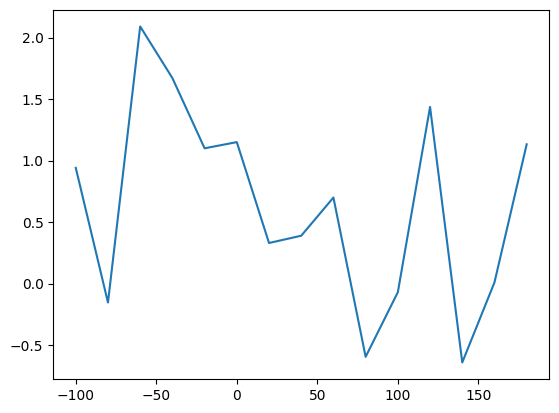

In [126]:
region = 'V4'
range_vals = monkey_brain_regions[region]
plt.plot(tb[::bin_size], binned_allmua[:, test_indices[0], range_vals[0]])

In [58]:
baseline_len = 100
mua0 = allmua[:baseline_len].mean(axis=0, keepdims=True)
mua0_std = allmua[:baseline_len].std(axis=0, keepdims=True)
allmua -= mua0
allmua /= mua0_std

In [60]:
allmua *= mua0_std
allmua += mua0

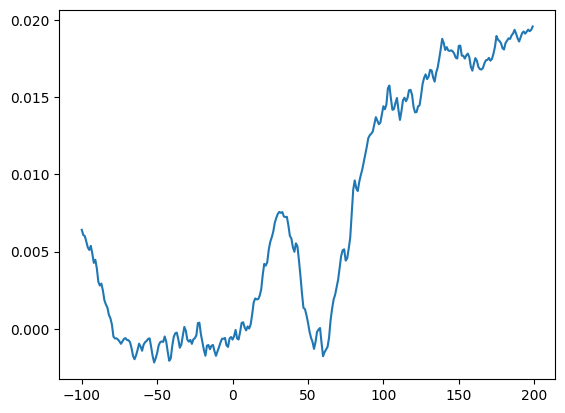

In [56]:
region = 'V4'
range_vals = monkey_brain_regions[region]
plt.plot(tb, allmua[:, train_indices, range_vals[0]+5].mean(1))

In [47]:
mua0.min(), mua0.max()

(3.4217695771789955, 156.13000824146556)

In [59]:
for region in monkey_brain_regions.keys():
    range_vals = monkey_brain_regions[region]
    region_electrodes = good_electrodes[range_vals[0]:range_vals[1]]
    # print min, max, for the region
    print(region, allmua[:, :, range_vals[0]:range_vals[1]][..., region_electrodes].min(), allmua[:, :, range_vals[0]:range_vals[1]][..., region_electrodes].max())

V1 -198.72205614871393 1278.7326069341814
IT -114.07829563514812 862.2479100980887
V4 -177.16258622582805 990.7211471426812


In [ ]:
for region in monkey_brain_regions.keys():
    range_vals = monkey_brain_regions[region]
    region_electrodes = good_electrodes[range_vals[0]:range_vals[1]]
    # print min, max, for the region
    print(region, allmua[:, :, range_vals[0]:range_vals[1]][..., region_electrodes].min(), allmua[:, :, range_vals[0]:range_vals[1]][..., region_electrodes].max())

V1 -40.22789864831919 234.81845181290885
IT -8.220867362231578 62.13649724351057
V4 -33.42746616810028 222.78365176347913


In [124]:
for brain_region in monkey_brain_regions.keys():
    region_start, region_end = monkey_brain_regions[brain_region]
    region_electrodes = good_electrodes[region_start:region_end]
    if len(deleted_index_dict[brain_region]) > 0:
        delete_index_list = np.array(deleted_index_dict[brain_region]) - region_start
        region_electrodes[delete_index_list] = False
    print(f"{brain_region}: {region_electrodes.sum()} good electrodes out of {region_end - region_start}")

    # store the train data as h5 file with image things paths and mua activity
    train_data_file = f"{data_dir}/{monkey_name}_THINGS_MUA_{brain_region}_train.h5"
    with h5py.File(train_data_file, "w") as f:
        f.create_dataset("images", data=train_images_arr) # [n_samples, height, width, channels]
        data = binned_allmua[:, train_indices, region_start:region_end]
        data = np.transpose(data, (1, 2, 0))[:, region_electrodes, :]  # [n_samples, n_electrodes, T]
        f.create_dataset("mua", data=data)

    # store the val data as h5 file with image things paths and mua activity
    val_data_file = f"{data_dir}/{monkey_name}_THINGS_MUA_{brain_region}_val.h5"
    with h5py.File(val_data_file, "w") as f:
        f.create_dataset("images", data=val_images_arr) # [n_samples, height, width, channels]
        data = binned_allmua[:, val_indices, region_start:region_end]
        data = np.transpose(data, (1, 2, 0))[:, region_electrodes, :]  # [n_samples, n_electrodes, T]
        f.create_dataset("mua", data=data)

    # store the test data as h5 file with image things paths and mua activity
    test_data_file = f"{data_dir}/{monkey_name}_THINGS_MUA_{brain_region}_test.h5"
    with h5py.File(test_data_file, "w") as f:
        f.create_dataset("images", data=test_images_arr) # [n_samples, height, width, channels]
        data = binned_allmua[:, test_indices, region_start:region_end]
        data = np.transpose(data, (1, 2, 0))[:, region_electrodes, :]  # [n_samples, n_electrodes, T]
        f.create_dataset("mua", data=data)

V1: 330 good electrodes out of 512
IT: 156 good electrodes out of 320
V4: 116 good electrodes out of 192


## Check VQVAE

In [ ]:
import sys
sys.path.append('/home/kaiwensheng/Work/Spont2Vision/')
from downstream_task.model.reconstruction.stsbench.reconstruction.models.vqvae import VQVAE
from downstream_task.model.reconstruction.stsbench.reconstruction.utils import load_config, set_seed


In [ ]:
config = load_config("/home/kaiwensheng/Work/Spont2Vision/downstream_task/model/reconstruction/stsbench/reconstruction/configs/ventral_stream_diffusion.yaml")

In [ ]:
dataset_config = config['dataset_params']
autoencoder_model_config = config['autoencoder_params']
train_config = config['train_params']
device = 'cuda:1'

vae = VQVAE(im_channels=dataset_config['im_channels'],
            model_config=autoencoder_model_config).to(device)

In [ ]:
vae.requires_grad_ = False
vae.eval()

vae.load_state_dict(torch.load(os.path.join(train_config['ckpt_dir'], train_config['vqvae_autoencoder_ckpt_name']), map_location=device))

<All keys matched successfully>

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].


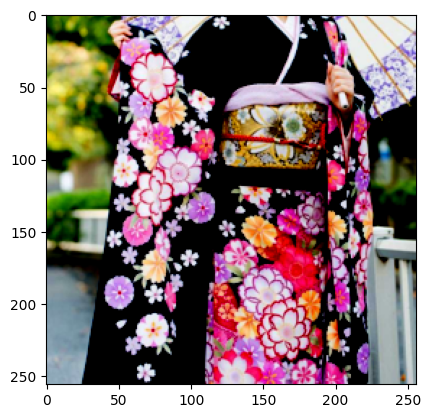

In [ ]:
img = train_images_arr[0]
plt.imshow(img)

In [ ]:
recon_img = vae.forward(torch.tensor(img.transpose(2,0,1)).unsqueeze(0).to('cuda:1'))[0][0].detach().cpu().numpy().transpose(1,2,0)

In [ ]:
recon_img.shape

(256, 256, 3)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.3979931..1.4732943].


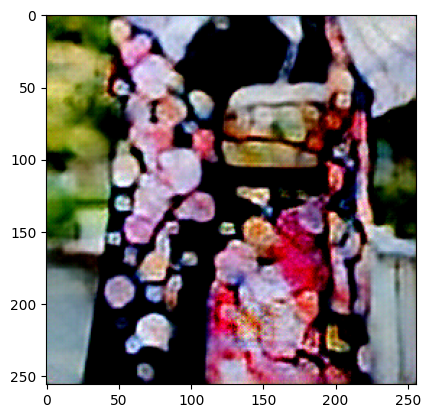

In [ ]:
plt.imshow(recon_img)